<a href="https://colab.research.google.com/github/zelihakarapinar/zelihakarapinar/blob/main/CWRU_Bearing_1D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive') # Mount Google Drive to access datasets and save models

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import pandas as pd
# Load the merged and labeled vibration dataset (4096-point windows)
file_path = '/content/drive/MyDrive/SAYZEK/beginning/combined_trainingrawdata.csv'
df = pd.read_csv(file_path)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3427 entries, 0 to 3426
Columns: 4097 entries, DE_0001 to Label
dtypes: float64(4096), object(1)
memory usage: 107.1+ MB


In [6]:
# Separate input features (X) and target labels (Y)
X = df.iloc[:, :4096].values  # First 4096 columns contain signal data
Y = df['Label'].values        # Last column contains the class labels

# Print the shapes to verify the datas
print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (3427, 4096)
Y shape: (3427,)


In [7]:
import joblib

encoder = LabelEncoder()
encoded_Y = encoder.fit_transform(Y)      # Convert string labels to integer indices
OHE_Y = to_categorical(encoded_Y)         # One-hot encode the integer labels

# Save the encoder to disk to use it later during inference
joblib.dump(encoder, '/content/drive/MyDrive/SAYZEK/beginning/encoder.pkl')

# Check the shape of the one-hot encoded labels
print("Encoded Y shape:", OHE_Y.shape)


Encoded Y shape: (3427, 4)


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, OHE_Y, test_size=0.2, stratify=Y, random_state=42)

# Normalize input features (standard scaling)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit the scaler only on training data
X_test = scaler.transform(X_test)        # Use the same scaler on test data

# Save the fitted scaler for future use
joblib.dump(scaler, '/content/drive/MyDrive/SAYZEK/beginning/scaler.pkl')

# Reshape input data to match Conv1D input requirements: (samples, time_steps, 1 channel)
X_train = X_train.reshape(-1, 4096).transpose(0, 1)
X_test = X_test.reshape(-1, 4096).transpose(0, 1)

# Print dataset shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (2741, 4096)
X_test shape: (686, 4096)
y_train shape: (2741, 4)
y_test shape: (686, 4)


In [9]:
model = Sequential()

# First 1D Convolutional Layer with 64 filters and ReLU activation
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(4096,1), padding='same'))
model.add(BatchNormalization())          # Normalize activations
model.add(MaxPooling1D(pool_size=2))     # Downsample by factor of 2
model.add(Dropout(0.3))                  # Dropout to prevent overfitting

# Second 1D Convolutional Layer with 128 filters
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Flatten the output for the fully connected layers
model.add(Flatten())

# Fully connected layer with ReLU activation
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout before final output layer

# Output layer with softmax activation for multi-class classification
model.add(Dense(len(encoder.classes_), activation='softmax'))

# Compile the model with Adam optimizer and categorical crossentropy loss
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Show the model architecture
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 4096, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4096, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2048, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2048, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2048, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1024, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,803,588 (64.10 MB)

 Trainable params: 16,803,204 (64.10 MB)

 Non-trainable params: 384 (1.50 KB)

In [10]:
# Define training parameters
batch_size = 128
epochs = 500

# Train the model with validation data
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    shuffle=True,   # Shuffle training data every epoch
    verbose=1       # Show training progress
)


Epoch 1/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 328ms/step - accuracy: 0.4734 - loss: 8.4356 - val_accuracy: 0.1312 - val_loss: 20.3981
Epoch 2/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.6443 - loss: 0.8738 - val_accuracy: 0.1370 - val_loss: 38.6360
Epoch 3/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.6686 - loss: 0.7100 - val_accuracy: 0.1385 - val_loss: 54.7635
Epoch 4/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.7383 - loss: 0.5966 - val_accuracy: 0.1385 - val_loss: 68.2667
Epoch 5/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.7900 - loss: 0.4578 - val_accuracy: 0.1385 - val_loss: 84.8713
Epoch 6/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.8270 - loss: 0.4021 - val_accuracy: 0.1385 - val_loss: 101.6215
Epoch 7/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.8365 - loss: 0.3799 - val_accuracy: 0.1385 - val_loss: 114.5696
Epoch 8/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.8474 - loss: 0.3464 - val_a

In [13]:
print("Model input shape:", model.input_shape)

Model input shape: (None, 4096, 1)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9658 - loss: 0.4359
Test Accuracy: 96.94%
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


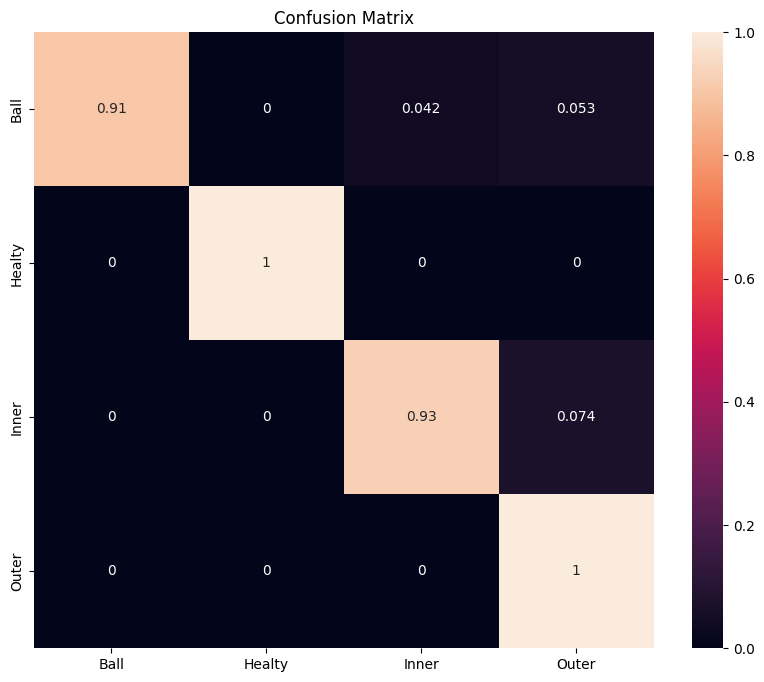

In [12]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert one-hot predictions to class indices
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Generate a normalized confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, normalize='true')

# Plot the confusion matrix for better visualization of class performance
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.show()


In [15]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.utils import to_categorical

def predict_and_count(test_file_path, model, encoder, scaler_path):
    # Load test CSV file containing vibration signals
    df = pd.read_csv(test_file_path)
    X = df.iloc[:, :4096].values

    # Load scaler and apply same normalization as training
    scaler = joblib.load(scaler_path)
    X_scaled = scaler.transform(X)

    # Reshape input for prediction
    X_reshaped = X_scaled.reshape(-1, 4096)

    # Predict class probabilities
    predictions = model.predict(X_reshaped)
    predicted_indices = np.argmax(predictions, axis=1)

    # Decode class indices to original labels
    predicted_labels = encoder.inverse_transform(predicted_indices)
    confidence = np.max(predictions, axis=1)  # Max softmax score per sample

    # Count number of predictions per class
    class_counts = {cls: np.sum(predicted_labels == cls) for cls in encoder.classes_}
    majority_class = max(class_counts, key=class_counts.get)

    # Set fault diagnosis summary
    diagnosis = f"{majority_class} fault" if majority_class != 'healthy' else 'healthy'

    # Print class count breakdown
    print("\nPrediction Counts:")
    for cls, count in class_counts.items():
        print(f"{cls}: {count}")

    print(f"\nFinal Diagnosis: {diagnosis}")

    return {
        "diagnosis": diagnosis,
        "majority_class": majority_class,
        "predicted_labels": predicted_labels,
        "confidence": confidence,
        "X_raw": X,  # Save raw signal for further harmonic analysis
        "encoder": encoder,
    }


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step

Prediction Counts:
Ball: 0
Healty: 0
Inner: 2
Outer: 116

Final Diagnosis: Outer fault


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft

# Function to compute RMS energy around fault harmonics in frequency domain
def compute_harmonic_rms(velocity_batch, fault_freq, sampling_freq=48000,
                        num_harmonics=6, sideband_bins=2):
    """Calculate RMS energy around harmonics of a fault frequency"""
    num_samples = len(velocity_batch)

    # Perform FFT on the signal batch
    fft_result = np.fft.rfft(velocity_batch)
    freq_res = sampling_freq / num_samples
    total_energy = 0.0

    # Loop through each harmonic and calculate energy
    for harmonic in range(1, num_harmonics + 1):
        center_freq = harmonic * fault_freq

        # Skip if harmonic is beyond Nyquist limit
        if center_freq > sampling_freq / 2:
            continue

        # Determine the FFT bin index for the harmonic frequency
        bin_center = int(round(center_freq / freq_res))
        lower = max(bin_center - sideband_bins, 0)
        upper = min(bin_center + sideband_bins, len(fft_result) - 1)

        # Sum energy in the sideband bins
        for bin_idx in range(lower, upper + 1):
            magnitude = np.abs(fft_result[bin_idx])

            # Apply energy scaling (DC term unscaled, others doubled)
            scale_factor = 1 if bin_idx == 0 else 2
            total_energy += (magnitude ** 2) * scale_factor

    # Convert accumulated energy to RMS
    return np.sqrt(total_energy) / num_samples


In [17]:
# Analyze signal batches with highest harmonic RMS energy for detected fault
def analyze_important_windows(results, X, shaft_speed_rpm=1761, top_n=5):
    """Find top batches with highest harmonic energy for the predicted fault class"""

    # Retrieve the majority fault class predicted
    majority_class = results["majority_class"]
    encoder = results["encoder"]

    # Convert RPM to Hz
    shaft_speed_hz = shaft_speed_rpm / 60

    # Define expected fault frequencies based on known relationships
    fault_frequencies = {
        'Outer': 3.585 * shaft_speed_hz,
        'BPFI': 5.415 * shaft_speed_hz,
        'FTF': 0.3983 * shaft_speed_hz,
        'BSF': 2.357 * shaft_speed_hz
    }
    fault_freq = fault_frequencies.get(majority_class, 0)

    # Filter samples predicted as the same class
    fault_mask = results["predicted_labels"] == majority_class
    batch_indices = np.where(fault_mask)[0]

    # Calculate harmonic RMS energy for each sample
    rms_values = []
    for idx in batch_indices:
        batch_data = X.iloc[idx].values
        rms = compute_harmonic_rms(batch_data, fault_freq)
        rms_values.append(rms)

    # Select top-N windows with highest harmonic energy
    top_indices = np.argsort(rms_values)[-top_n:][::-1]
    top_batches = batch_indices[top_indices]

    return {
        "diagnosis": f"Detected {majority_class} fault",
        "fault_frequency": f"{fault_freq:.2f} Hz",
        "harmonics_analyzed": 5,
        "top_batches": pd.DataFrame({
            'Batch Index': top_batches,
            'RMS (mm/s)': np.array(rms_values)[top_indices],
            'Confidence': results["confidence"][top_batches]
        }),
        "average_rms": np.mean(rms_values)
    }


In [18]:
if __name__ == "__main__":
    # Load previously saved encoder
    encoder = joblib.load('/content/drive/MyDrive/SAYZEK/beginning/encoder.pkl')

    # Path to test data
    test_file_path = '/content/drive/MyDrive/SAYZEK/beginning/outer265racefault_testrawdata.csv'

    # Run fault prediction
    result = predict_and_count(
        test_file_path,
        model=model,
        encoder=encoder,
        scaler_path='/content/drive/MyDrive/SAYZEK/beginning/scaler.pkl'
    )

    # Run harmonic RMS analysis on faulty samples
    analysis = analyze_important_windows(result, pd.DataFrame(result["X_raw"]))

    # Print diagnostic summary
    print(f"\n=== FAULT DIAGNOSIS ===")
    print(f"{analysis['diagnosis']} | Fundamental Frequency: {analysis.get('fault_frequency', '-')}")
    if "top_batches" in analysis:
        print(f"\nTop {len(analysis['top_batches'])} Diagnostic Batches (3 harmonics):")
        print(analysis['top_batches'])
        print(f"\nAverage RMS for detected fault: {analysis['average_rms']:.2f} mm/s")



=== FAULT DIAGNOSIS ===
Detected Outer fault | Fundamental Frequency: 105.22 Hz

Top 5 Diagnostic Batches (3 harmonics):
   Batch Index  RMS (mm/s)  Confidence
0           94    0.177319    0.999921
1           30    0.156602    1.000000
2           76    0.155552    0.999993
3           74    0.154716    1.000000
4           97    0.154613    1.000000

Average RMS for detected fault: 0.13 mm/s


In [19]:
# 1. Compute full frequency array (positive and negative frequencies)
full_freqs = np.fft.fftfreq(4096, d=1/24000)  # Sampling rate = 24kHz

# 2. Filter only positive frequencies (0 Hz to Nyquist)
positive_mask = full_freqs >= 0
positive_freqs = full_freqs[positive_mask]  # Shape = (2048,)

# 3. Truncate frequency axis to 0–500 Hz range for visualization
max_freq = 500  # Max frequency of interest
frequency_resolution = 24000 / 4096  # ≈11.719 Hz/bin
num_bins = int(np.floor(max_freq / frequency_resolution))
freqs_truncated = positive_freqs[:num_bins + 1]

print("Frequency range:", freqs_truncated[0], "to", freqs_truncated[-1], "Hz")


Frequency range: 0.0 to 498.046875 Hz


In [20]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Layer
import numpy as np

# Custom layer to compute DFT of the input signal
class DFTLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(DFTLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Convert input to complex format (squeeze last dimension)
        inputs_complex = tf.cast(tf.squeeze(inputs, axis=-1), tf.complex64)
        # Apply FFT (1D)
        dft_output = tf.signal.fft(inputs_complex)
        # Return real and imaginary parts stacked as separate channels
        return tf.stack([tf.math.real(dft_output), tf.math.imag(dft_output)], axis=-1)

    def compute_output_shape(self, input_shape):
        # Output shape: (batch_size, time_steps, 2 channels)
        return (input_shape[0], input_shape[1], 2)


# Define model using Keras Sequential API
model_DFT = models.Sequential()

# Input shape: (timesteps = num_bins+1, channels = 1)
model_DFT.add(layers.InputLayer(input_shape=(num_bins + 1, 1)))

# Apply custom DFT Layer
model_DFT.add(DFTLayer())

# First convolutional block
model_DFT.add(layers.Conv1D(64, 3, activation='relu', padding='same'))
model_DFT.add(layers.BatchNormalization())
model_DFT.add(layers.MaxPooling1D(2))
model_DFT.add(layers.Dropout(0.3))

# Second convolutional block
model_DFT.add(layers.Conv1D(128, 3, activation='relu', padding='same'))
model_DFT.add(layers.BatchNormalization())
model_DFT.add(layers.MaxPooling1D(2))
model_DFT.add(layers.Dropout(0.3))

# Flatten and fully connected layers
model_DFT.add(layers.Flatten())
model_DFT.add(layers.Dense(128, activation='relu'))
model_DFT.add(layers.Dropout(0.5))
model_DFT.add(layers.Dense(5, activation='softmax'))  # Adjust to your number of classes

# Compile the model with Adam optimizer and categorical crossentropy loss
model_DFT.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model_DFT.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dft_layer (DFTLayer)            │ (None, 86, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 86, 64)         │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 86, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 43, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 43, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 43, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 43, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2688)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       344,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 370,757 (1.41 MB)

 Trainable params: 370,373 (1.41 MB)

 Non-trainable params: 384 (1.50 KB)

In [21]:
import shap

In [73]:
# Load raw test data from CSV file
test_file_path = '/content/drive/MyDrive/SAYZEK/beginning/outer265racefault_testrawdata.csv'
df2 = pd.read_csv(test_file_path)

# Extract signal data (assuming 4096-sample windows)
X_raw = df2.iloc[:, :4096].values

# Define sampling frequency and time vector
sampling_freq = 24000  # Hz
numofsamples = 4096
time = np.linspace(0, numofsamples / sampling_freq, numofsamples)

# Compute FFT for all samples
X_DFT = np.fft.fft(X_raw)

# Select a single sample to analyze (e.g., index 60)
X_DFT_sample = np.fft.fft(X_raw[88])

# Define frequency resolution and frequency range to truncate
max_freq = 500  # Hz
frequency_resolution = sampling_freq / numofsamples  # ~11.72 Hz/bin
num_bins = int(max_freq // frequency_resolution)  # ~170 bins (0–500 Hz)

# Truncate frequency-domain data for background and target sample
X_DFT_truncated = X_DFT[:, :num_bins + 1]
X_DFT_sample_truncated = X_DFT_sample[:num_bins + 1]

# Create corresponding frequency array and magnitude spectrum
freq = np.fft.fftfreq(len(X_DFT_sample_truncated), 1 / sampling_freq)[:2048]
magnitude = np.abs(X_DFT_sample_truncated[:2048]) / 1000  # Optional normalization
#dsddsdf

In [74]:
# Use truncated FFT data as background for SHAP
background = X_DFT_truncated

# Initialize SHAP KernelExplainer using model prediction as function
explainer = shap.KernelExplainer(
    lambda x: model_DFT.predict(x.reshape(-1, num_bins + 1, 1)),
    background.reshape(118, -1),
    link="identity"
)

# Prepare the sample input for SHAP (reshape to match input shape)
sample = X_DFT_sample_truncated.reshape(1, -1)
print('sample shape', sample.shape)

# Compute SHAP values for all output classes
raw_shap = explainer.shap_values(sample)

# Select class index (e.g., 3 → 'outer' fault)
class_index = 3

# Extract SHAP values for the selected class
shap_values = raw_shap[..., class_index]  # Shape becomes (1, 4096)
shap_values = shap_values[0]  # Remove batch dimension → (4096,))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


sample shape (1, 86)


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
8187/8187 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


In [75]:
# Define shaft speed and compute in Hz
shaft_speed_rpm = 1750
shaft_speed_hz = shaft_speed_rpm / 60

# Time vector for plotting (not used here, but useful if needed)
window_length = 4096
fs = 24000  # Hz
t = np.linspace(0, window_length / fs, window_length)

# Compute characteristic bearing fault frequencies
bpfi = 5.415 * shaft_speed_hz   # Ball Pass Frequency Inner
bpfo = 3.5848 * shaft_speed_hz  # Ball Pass Frequency Outer
bsf = 2.357 * shaft_speed_hz    # Ball Spin Frequency
ftf = 0.3983 * shaft_speed_hz   # Fundamental Train Frequency

# Optional: color map for annotations
freq_colors = {
    'BSF': 'red',
    'BPFI': 'green',
    'BPFO': 'purple',
    'FTF': 'orange'
}


In [76]:
shap_values

array([ 0.        ,  0.        , -0.00069846,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.00171689,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.00253646,  0.        ,
        0.        ,  0.        ,  0.        , -0.00172896,  0.        ,
       -0.00256904,  0.        ,  0.        , -0.00321138,  0.        ,
        0.        , -0.00136283, -0.00607791, -0.00099941,  0.        ,
        0.        , -0.00084077,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

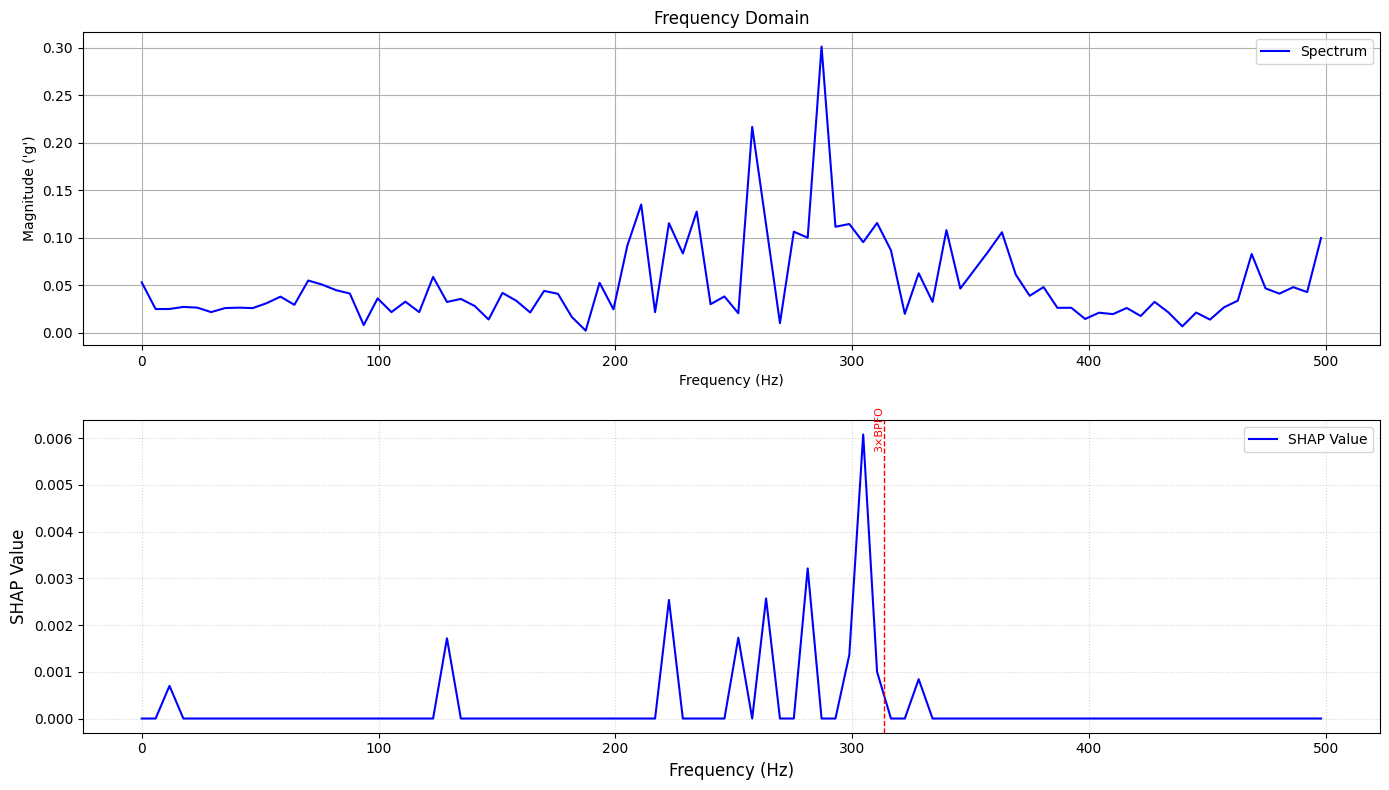

In [77]:
# Start plotting the frequency-domain spectrum and SHAP values
plt.figure(figsize=(14, 8))

# ---- Spectrum Plot ----
plt.subplot(2, 1, 1)
plt.plot(freqs_truncated, magnitude, 'b', label='Spectrum')
plt.title("Frequency Domain")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude ('g')")
plt.legend()
plt.grid(True)

# ---- SHAP Value Plot ----
plt.subplot(2, 1, 2)
plt.plot(freqs_truncated, np.abs(shap_values), 'b', label='SHAP Value', linewidth=1.5)

# Annotate fault-related frequency lines (e.g., multiples of BPFO)
for mult in [3]:  # You can add more harmonics
    freq = mult * bpfo
    plt.axvline(x=freq, color='red', linestyle='--', linewidth=1)
    plt.text(freq, plt.ylim()[1] * 0.9, f'{mult}×BPFO', rotation=90,
             fontsize=8, color='red', ha='right')

plt.xlabel('Frequency (Hz)', fontsize=12)
plt.ylabel('SHAP Value', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.5)

# Final layout adjustment
plt.tight_layout()
plt.show()
